In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d
import scipy.signal.windows as w

## Exercise 6.1: FMCW: Single Chirp

In [2]:
fs=1e6        # IF sample frequency
B=250e6       # RF bandwidth
fc=24.125e9   # carrier frequency
T=1e-3        # chirp duration
F_dB=12       # noise figure of the system
T0=270        # system temperature
R=50          # reference impedance

A0_arr=np.array([20, 18, 0.1, 2, 0.1])*1e-6  # magnitudes
r0_arr=np.array([0.001, 0.1, 15, 40, 80])    # ranges
v0_arr=np.array([0, 0, 1, 0, 28])            # range-rates

In [3]:
wave_speed = 299792458 # is the speed of light; 299,792,458 metres per second 
my_lambda = wave_speed/fc

N = int(fs*T)
n = np.arange(N)
#n = np.linspace(0, T, N, endpoint=False) # does not work --> line as plot output
#n = np.append(-np.flip(n/2),n/2)
sampling_interval = 1/fs
k = B/T

# to get noise std:
F= 10**(F_dB/10)
Te = F*T0-T0
kB = 1.38e-23 # Boltzmann constant
PN = kB*Te/T 
noise_std = np.sqrt(PN*R)
noise = noise_std * np.random.randn(len(n))

In [4]:
sif = []
sif_nm = np.zeros((len(n),len(A0_arr)))
for i in range(len(n)):
    phi_n = 2*fc*r0_arr/wave_speed + n[i]*sampling_interval*((2*k*r0_arr + 2*fc*v0_arr)/wave_speed) + n[i]**2*sampling_interval**2*(2*k*v0_arr/wave_speed)
    content = A0_arr * np.cos(2*np.pi*phi_n) 
    sif_n = np.sum(content) + noise[i]
    sif.append(sif_n)
    sif_nm[i] = content
magnitude_sif = abs(np.array(sif))

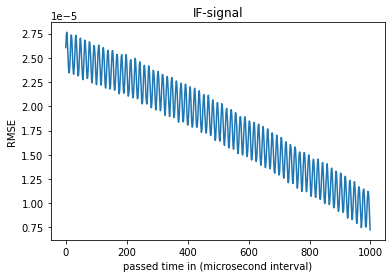

In [13]:
plt.plot(sif, label=f'')

#plt.plot(n*sampling_interval,sif, label=f'')
#plt.plot(df_lin+center, polynomial/normal, label='Polynomial')
#plt.scatter(off_f+center,off_phase,label='found freq. max peak of polynomial')
#plt.scatter(psi,np.angle(A),label='true parameter')

plt.xlabel('passed time in (microsecond interval)')
plt.ylabel('RMSE')
plt.title('IF-signal')
plt.show()

The targets are visibile in the frequency and amplitude of the target. In each sIF point information about all targets included. The noise is visible in the positive distance of the sIF to the x-axis when the y-axis gives us the magnitude of the signal.

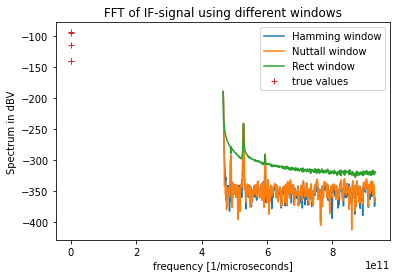

In [6]:
ham_wind = np.hanning(len(n)) # window over all 128 samples 
nut_wind = w.nuttall(len(n))
rect_wind = 1

fft_sig_ham = abs(np.fft.fft(sif*ham_wind)/np.sum(ham_wind))**2
fft_sig_dB_ham = 20*np.log10(fft_sig_ham)

f = np.fft.fftfreq(len(n), 1/fs)

#fft_sig_dB_normal_ham = fft_sig_dB_ham/Am[0]

fft_sig_nut = abs(np.fft.fft(sif*nut_wind)/np.sum(nut_wind))**2
fft_sig_dB_nut = 20*np.log10(fft_sig_nut)
#fft_sig_dB_normal_nut = fft_sig_dB_nut/Am[0]

fft_sig_rect = abs(np.fft.fft(sif*rect_wind)/len(n))**2
fft_sig_dB_rect = 20*np.log10(fft_sig_rect)
#fft_sig_dB_normal_rect = fft_sig_dB_rect/Am[0]


timestep = 1/(fs/1e6)
freq = np.fft.fftfreq(len(n), d=timestep) # contain sample f
idx = np.argsort(freq)
start_ind = np.where(idx==0)[0][0]

range_interval = np.linspace(0,100,len(n))


r = wave_speed * n * 0.5
r_m = r * my_lambda /(2*T)


#freq[idx][start_ind:],
plt.figure()
plt.plot(r_m[start_ind:],fft_sig_dB_ham[idx][start_ind:], label='Hamming window')
plt.plot(r_m[start_ind:],fft_sig_dB_nut[idx][start_ind:], label='Nuttall window')
plt.plot(r_m[start_ind:],fft_sig_dB_rect[idx][start_ind:], label='Rect window')
plt.plot(r0_arr, 10*np.log10(A0_arr**2),ls='',marker='+', label='true values')

plt.title('FFT of IF-signal using different windows')
plt.xlabel('frequency [1/microseconds]')
plt.ylabel('Spectrum in dBV')


plt.legend()
plt.show()

With the true range at 80 m we don't hit it in the spectrogram. Reason: the Normalized frequency fromula shows us that f is proportional to range but also to range rate. This means we can't distinguish a target further away from a moving target when using the single chirp.<br>
Target at range 15 would be overseen by rectengular window because it is quite below the course of the spectrum's sidelopes origing of high power reflections at low distances.

## Exercise 6.2: 2D-FFT

In [7]:
fs=10e6       # IF sample frequency
B=250e6       # RF bandwidth
fc=24.125e9   # carrier frequency
T=50e-6       # ramp duration
Tp=100e-6     # chirp repetition rate
Np=64         # number of pulses
Temp_sys=9e5  # equivalent noise temperature
R=50          # reference impedance

A0_arr=np.array([20, 18, 0.1, 2, 0.1, 4])*1e-3   # magnitudes
r0_arr=np.array([0.001, 0.1, 15, 40, 80, 50])    # ranges
v0_arr=np.array([0, 0, 1, 0, 28, -84])           # velocities

In [8]:
Ts = 1/fs
k = B/T


N = int(fs*T)
n = np.linspace(0, T, N, endpoint=False)
n = np.arange(N)#1e5)


# to get noise std:
kB = 1.38e-23 # Boltzmann constant
PN = kB*Temp_sys/T 
noise_std = np.sqrt(PN*R)
noise = noise_std * np.random.randn(len(n),Np)

In [9]:
sif_nnp = np.zeros((len(n),Np))
for n_ in n:
    for np_ in range(Np):
        phi_nnp = np_*Tp*2*fc*v0_arr/wave_speed + n_*Ts*(2*k*r0_arr/wave_speed + 2*fc*v0_arr/wave_speed) + 2*fc*r0_arr/wave_speed + n_**2*Ts**2*2*k*v0_arr/wave_speed + n_*np_*Ts*Tp*2*k*v0_arr/wave_speed
        
        content = A0_arr * np.cos(2*np.pi*phi_nnp) 
        sif_nnp[n_,np_] = np.sum(content) + noise[n_,np_]

/home/c/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  if sys.path[0] == "":


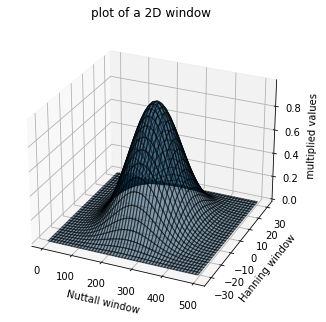

In [14]:
nut_wind = w.nuttall(len(n)) # fast-time, no plot of neg f; ranges
han_wind = np.hanning(Np) # slow-time, no plot neg and pos f; range_rates

nut_rep = nut_wind.reshape(1,-1).repeat(Np,axis=0).T
han_rep = han_wind.reshape(1,-1).repeat(len(n),axis=0)
combi_wind = nut_rep*han_rep

X,Y = np.meshgrid(n ,np.arange(-int(Np/2),int(Np/2)))

fig=plt.figure()
fig.clear()
ax=fig.gca(projection='3d')
ax.view_init(elev=27,azim=-66)
plt.tight_layout(pad=0.0,rect=(-0.1,0,1,1))
ax.plot_surface(X.T,Y.T,combi_wind,alpha=0.5,edgecolor='k')
plt.xlabel('Nuttall window')
plt.ylabel('Hanning window')
ax.set_zlabel('multiplied values')
plt.title('plot of a 2D window')
plt.show()

In [11]:
fft_combi = np.fft.fft2(sif_nnp*combi_wind, s=(90,Np))
fft_combi = np.fft.fftshift(fft_combi, axes=1)

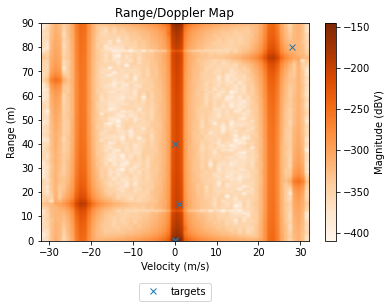

In [15]:
fft_power_log = 20*np.log10(abs(fft_combi/np.sum(combi_wind))**2)
plt.imshow(fft_power_log,
           cmap='Oranges',
           vmax=np.max(fft_power_log),
           vmin=np.min(fft_power_log),
           origin='lower', aspect='auto',
           extent=(-int(Np/2),int(Np/2),0,90))
plt.xlabel('Velocity (m/s)')
plt.ylabel('Range (m)')
plt.colorbar(label='Magnitude (dBV)')
plt.title('Range/Doppler Map')
plt.plot(v0_arr[:-1], r0_arr[:-1], 'x', label='targets') # last value is in velocity out of range, therefore
# we let it out here
plt.legend(loc='lower center', bbox_to_anchor=(0.5, -0.3))
plt.show()

solution diagram: recording was muted at this point. However, for the range you can see that over its full range the found targets are clearly separated from the non-targets with the highest magnitude values. Velocity is a bit harder to process. Here is not always clear if we have a target which is visualized by strides (certain ambiguity given). For bright regions it is always clear that no target is assumed there. 

We sampled the signal. Meanwhile we are taking samples the target moves. When it moves really fast we could miss the target as it leaves the radar value range fast. However, some samples still catched it when it passed through. Therefore, we get a wrong value.

## Homework 6.1: Calculation Time Considerations

Of course it makes sense to reduce the size of matrices and vectors first before making complex computationation, like taking the inverse of a big matrix. The smaller the vectors/matrices the less heavy are complex tasks. <br>
'taking the logarithm' also handles complex input values. It would be computationally more heavy than simply computing on the basis on real values. The problem is that there are several solutions to solve the logarithmic equation $$10^{\text{log_output_x}} = \text{complex_input_number}$$. Therefore, it makes sense to calculate the magnitude before. Here the calculation to solve is much easier with $$\sqrt{\text{real_part}^2 + \text{imaginary_part}^2}$$ with $$\text{complex_number} = \text{real_part}+\text{imaginary_part}\cdot i$$.<br>
The shifting of the velocity is an ax shift like ' shift = [x.shape[ax] // 2 for ax in axes] ' 
(https://github.com/numpy/numpy/blob/v1.24.0/numpy/fft/helper.py#L19-L73) and then using np.roll() which shifts elements which are out of range on the right into the left side of the array. The first operation is very simple. For the second operation it becomes clear that doing so it could be a bit faster for shorter vectors. However, when the matrix/vector size stays same it should not matter in complexity. However, a complex number requires more bits for storage. Therefore, it makes sense to make the shift at least after taking the magnitude. <br>
'cropping range' becomes interesting after forming the FFT. With only looking at a window/part of all values we have a smaller matrix to handle and therefore less memory consumption and less complexity issues in taking further computational steps. Making it first makes sense.<br>
When window scaling a window function it makes sense for a smaller window. When we form a window it shouldn't be influenced by other operation like cropping. Therefore, its size shouldn't vary and the scaling of the window function can be done at any time, but in best when the window is getting initialized in the moment. So we don't have to point again to its storage place at a later time point. <br>
Same accounts for the calculation of the square magnitude. Best do it when the magnitude is getting initialized.